#### Mapa Geral

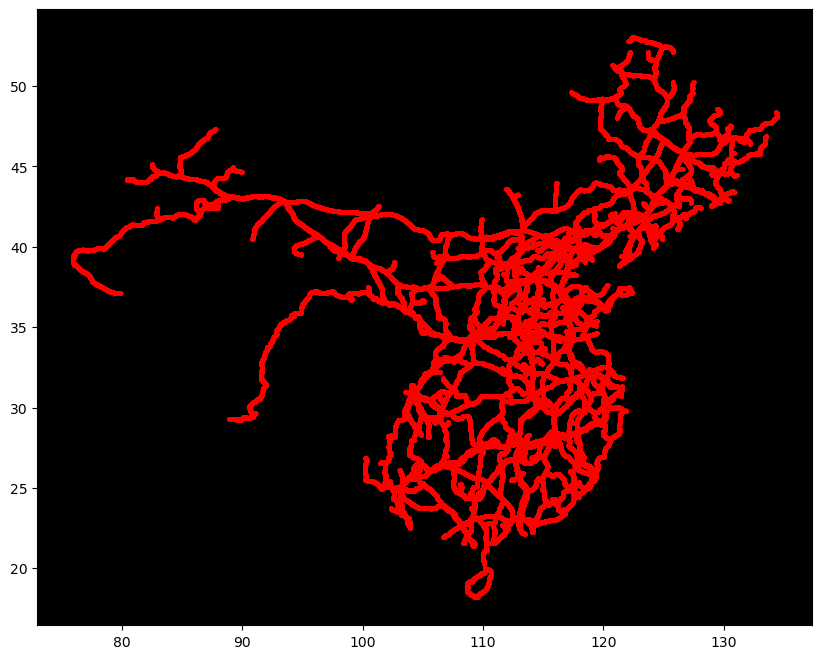

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(merged['long'], merged['lat'], s=5, color='red')
ax.set_facecolor('black')
plt.show()


#### Dataframe

In [4]:
import pandas as pd

origem1 = pd.read_csv('seg_info_rail.csv')
origem2 = pd.read_csv('seg_pixel_rail.csv')

origem1.columns = origem1.columns.str.strip() #remover os espaços de seg_id -> o segundo df veio com alguns espaços no nome da coluna
origem2.columns = origem2.columns.str.strip()
origem1['seg_id'] = origem1['seg_id'].astype(str).str.strip().str.lower() 
origem2['seg_id'] = origem2['seg_id'].astype(str).str.strip().str.lower()

origem2 = origem2.merge(origem1[['seg_id', 'year']], on='seg_id', how='left')
trilhos = origem2

In [5]:
trilhos = trilhos.drop_duplicates(['seg_id', 'long', 'lat'])

In [77]:
trilhos.sort_values(['seg_id', 'index'])

,seg_id,long,lat,pos_x,pos_y,index,year
126,rail_1,117.2120,39.1238,8161,3861,72048501,1888
125,rail_1,117.2184,39.1280,8162,3860,72057329,1888
124,rail_1,117.2180,39.1235,8162,3861,72057330,1888
123,rail_1,117.2176,39.1190,8162,3862,72057331,1888
122,rail_1,117.2231,39.1142,8163,3863,72066161,1888
...,...,...,...,...,...,...,...
15590,rail_99,125.6444,42.5397,9443,2956,83366374,1927
15593,rail_99,125.6516,42.5435,9444,2955,83375202,1927
15591,rail_99,125.6506,42.5390,9444,2956,83375203,1927
15592,rail_99,125.6568,42.5383,9445,2956,83384032,1927


#### Mapa 1 - clusters no mapa

In [23]:
import folium
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from branca.element import Template, MacroElement
from folium.plugins import MarkerCluster

gdf_points_wgs84 = gdf_points.to_crs(epsg=4326) # transforma para o sistema de coordenadas EPSG:4326, que é o WGS84 - padrões de latitude e longitude

# PALETA E DÉCADAS
decadas = sorted(
    gdf_points_wgs84['decade'].dropna().unique(),
    key=lambda x: int(x.rstrip('s')) if x != 'Sem Data' else -1)

colors = plt.cm.plasma(np.linspace(0, 1, len(decadas)))
hex_colors = [matplotlib.colors.rgb2hex(c) for c in colors]

# AMOSTRAGEM PARA REDUZIR QUANTIDADE DE PONTOS

frac_amostra = 0.2  # 20% dos pontos, ajuste para menos
gdf_sample = gdf_points_wgs84.sample(frac=frac_amostra, random_state=42)

# MAPA FOLIUM
m = folium.Map(location=[35, 105], zoom_start=4, tiles="OpenStreetMap")

# MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# pontos por década
for decada, color in zip(decadas, hex_colors):
    subset = gdf_sample[gdf_sample['decade'] == decada]
    for _, row in subset.iterrows():
        folium.Circle(
            location=[row.geometry.y, row.geometry.x],
            radius=5000,  # em metros, ajuste para seu zoom e escala
            color=color,
            fill=True,
            fill_opacity=0.6,
            tooltip=f"seg_id: {row['seg_id']}<br>year: {row['year']}<br>decade: {row['decade']}"
        ).add_to(marker_cluster)

# LEGENDA + PALETA PLASMA

template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: auto; 
     z-index:9999; font-size:14px;
     background-color: white;
     border:2px solid grey;
     padding:10px;">
<h4>Décadas</h4>
<ul style="list-style: none; padding:0;">
""" + "\n".join([f'<li><span style="background:{c};width:15px;height:15px;display:inline-block;margin-right:5px;"></span>{d}</li>' 
                for d, c in zip(decadas, hex_colors)]) + """
</ul>
</div>
{% endmacro %}
"""
macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

m.save("clustersferroviarioschina.html")
print("custers ok! ")


custers ok! 


#### Mapa 2 - com pontos traçejados

In [22]:
import folium
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from branca.element import Template, MacroElement

gdf_points_wgs84 = gdf_points.to_crs(epsg=4326) # transforma para o sistema de coordenadas EPSG:4326, que é o WGS84 - padrões de latitude e longitude

# PALETA E DÉCADAS
decadas = sorted(
    gdf_points_wgs84['decade'].dropna().unique(),
    key=lambda x: int(x.rstrip('s')) if x != 'Sem Data' else -1)

colors = plt.cm.plasma(np.linspace(0, 1, len(decadas)))
hex_colors = [matplotlib.colors.rgb2hex(c) for c in colors]

# AMOSTRAGEM PARA REDUZIR QUANTIDADE DE PONTOS

frac_amostra = 0.3  # ajuste: 0.1 = 10% dos pontos
gdf_sample = gdf_points_wgs84.sample(frac=frac_amostra, random_state=42)

# MAPA FOLIUM
m = folium.Map(location=[35, 105], zoom_start=4, tiles="OpenStreetMap")

# pontos por década
for decada, color in zip(decadas, hex_colors):
    subset = gdf_sample[gdf_sample['decade'] == decada]
    for _, row in subset.iterrows():
        folium.Circle(
            location=[row.geometry.y, row.geometry.x],
            radius=2000,   # em metros
            color=color,
            fill=True,
            fill_opacity=0.5,
            tooltip=f"<b>seg_id:</b> {row['seg_id']}<br><b>year:</b> {row['year']}<br><b>decade:</b> {row['decade']}"
        ).add_to(m)

# LEGENDA + PALETA PLASMA

template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: auto; 
     z-index:9999; font-size:14px;
     background-color: white;
     border:2px solid grey;
     padding:10px;">
<h4>Décadas</h4>
<ul style="list-style: none; padding:0;">
""" + "\n".join([f'<li><span style="background:{c};width:15px;height:15px;display:inline-block;margin-right:5px;"></span>{d}</li>' 
                for d, c in zip(decadas, hex_colors)]) + """
</ul>
</div>
{% endmacro %}
"""
macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

m.save("malhaferroviariachina.html")
print("mapa ok")

mapa ok


In [ ]:
colors = plt.cm.plasma(np.linspace(0, 1, len(decadas))) #plasma utilizado nas cores